In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2020-12-23 04:40:57--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  4.09MB/s    in 54s     

2020-12-23 04:41:51 (4.40 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [5]:
!tar -zxf maps.tar.gz

In [6]:
!ls

gdrive	maps  maps.tar.gz  sample_data


In [4]:
import glob
train_files = glob.glob('maps/train/*.jpg')
test_files = glob.glob('maps/val/*.jpg')

In [5]:
len(train_files), len(test_files)

(1096, 1098)

In [6]:
import cv2
for file in train_files[:10]:
    map = cv2.imread(file)
    print (map.shape)

(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)


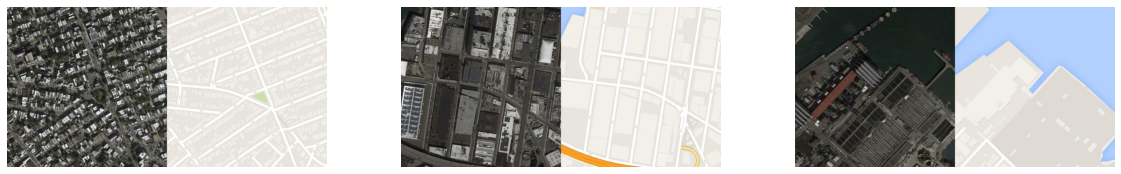

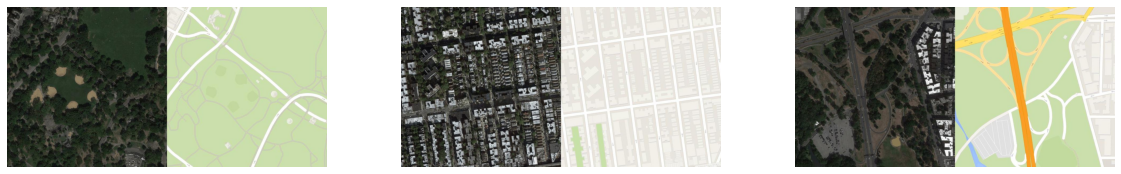

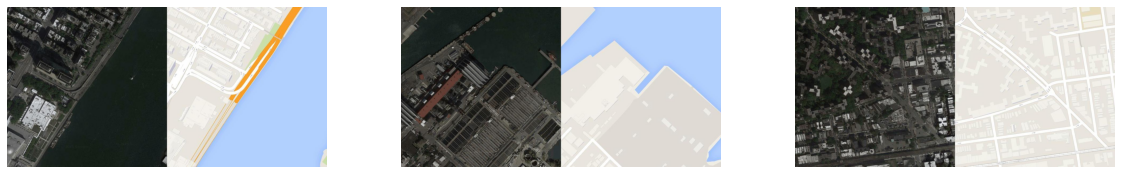

In [7]:
for k in range(3):
    plt.figure(figsize=(20, 10))
    for j in range(3):
        file = np.random.choice(train_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        plt.subplot(330 + 1 + j)
        plt.imshow(map)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

Input Images


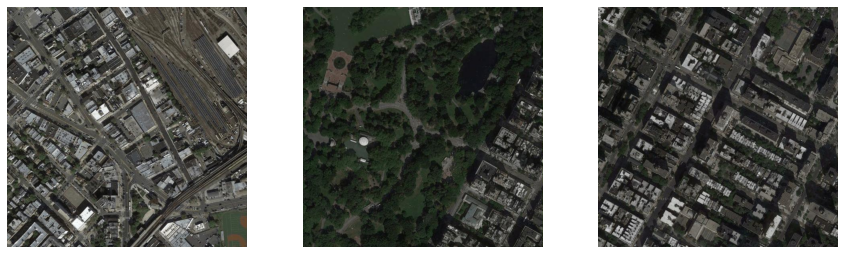

Output Images


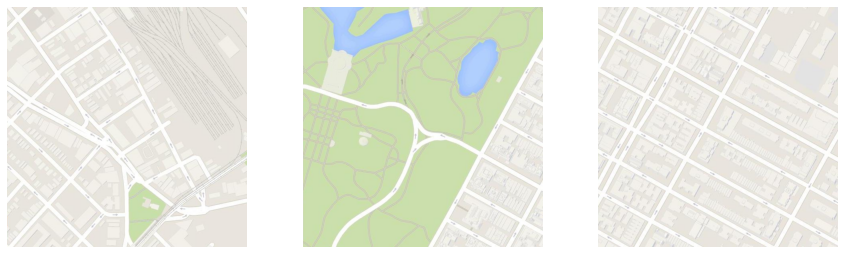

In [8]:
maps = []
for j in range(3):
    file = np.random.choice(train_files)
    map = cv2.imread(file)
    map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
    maps.append(map)

print ('Input Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map1 = map[:, :map.shape[1]//2]
    plt.subplot(330 + 1 + j)
    plt.imshow(map1)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

print ('Output Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map2 = map[:, map.shape[1]//2:]
    plt.subplot(330 + 1 + j)
    plt.imshow(map2)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

# Generator Model (U-Net Like)

In [9]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [11]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

e1 = encoder_layer(source_image_input, 64, bn=False)#64
e2 = encoder_layer(e1, 128)#128
e3 = encoder_layer(e2, 256)#256
e4 = encoder_layer(e3, 512)#512
e5 = encoder_layer(e4, 512)#512
e6 = encoder_layer(e5, 512)#512
e7 = encoder_layer(e6, 512)#512

bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 512)#512
d2 = decoder_layer(d1, e6, 512)#512
d3 = decoder_layer(d2, e5, 512)#512
d4 = decoder_layer(d3, e4, 512)#512
d5 = decoder_layer(d4, e3, 256)#256
d6 = decoder_layer(d5, e2, 128)#128
d7 = decoder_layer(d6, e1, 64)#64

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network = tensorflow.keras.models.Model(inputs=source_image_input, outputs=translated_image)
print (generator_network.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

# Discriminator Network

In [12]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [13]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

combined = tensorflow.keras.layers.Concatenate(axis=-1)([source_image_input, target_image_input])

x = my_conv_layer(combined, 64, bn=False)#64
x = my_conv_layer(x, 128)#128
x = my_conv_layer(x, 256)#256
x = my_conv_layer(x, 512)#512

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[source_image_input, target_image_input], outputs=patch_features)
print (discriminator_network.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_14[0][0]       

In [14]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# pix2pix

In [15]:
discriminator_network.trainable=False

g_output = generator_network(source_image_input)
d_output = discriminator_network([source_image_input, g_output])

pix2pix = tensorflow.keras.models.Model(inputs=source_image_input, outputs=[d_output, g_output])
pix2pix.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  54429315    input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 16, 16, 1)    2771393     input_3[0][0]                    
                                                                 model_1[0][0]                    
Total params: 57,200,708
Trainable params: 54,419,459
Non-trainable params: 2,781,249
__________________________________________________________________________________________________


# Compiling Models

In [16]:
pix2pix.compile(loss=['mse', 'mae'], optimizer=adam_optimizer, loss_weights=[1, 100])

# Define Data Generators

In [17]:
def get_predictions(input_sample, generator_network):
    input_sample = np.expand_dims(input_sample, axis=0)
    output_sample = generator_network.predict_on_batch(input_sample)
    return output_sample

def get_generated_samples(generator_network, maps_input):
    generated_samples = generator_network.predict_on_batch(maps_input)
    return generated_samples

def get_map_samples(batch_size):
    random_files = np.random.choice(train_files, size=batch_size)
    maps_input = []
    maps_output = []
    for file in random_files:
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        map1 = map[:, :map.shape[1]//2]
        map2 = map[:, map.shape[1]//2:]
        map1 = cv2.resize(map1, (256, 256))
        map2 = cv2.resize(map2, (256, 256))
        maps_input.append((map1-127.5)/127.5)
        maps_output.append((map2-127.5)/127.5)
    maps_input = np.array(maps_input)
    maps_output = np.array(maps_output)
    return maps_input, maps_output

def show_generator_results(generator_network):
    maps = []
    for j in range(3):
        file = np.random.choice(test_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        maps.append(map)

    print ('Input Images')
    plt.figure(figsize=(13, 13))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map1)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Predicted Output Images')
    plt.figure(figsize=(13, 13))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        map1 = (map1-127.5)/127.5
        output = get_predictions(map1, generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(330 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Real Output Images')
    plt.figure(figsize=(13, 13))
    for j, map in enumerate(maps):
        map2 = map[:, map.shape[1]//2:]
        map2 = cv2.resize(map2, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map2)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [18]:
len(train_files)

1096

Input Images


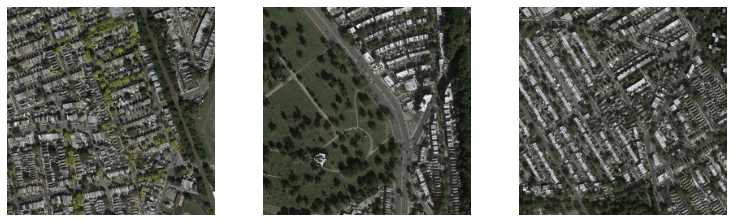

Predicted Output Images


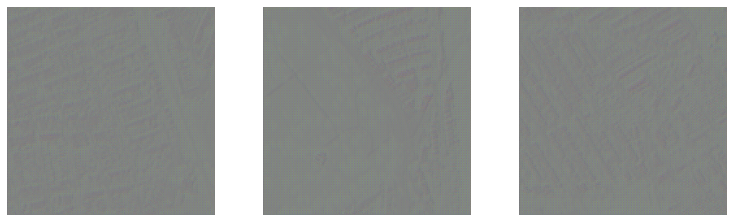

Real Output Images


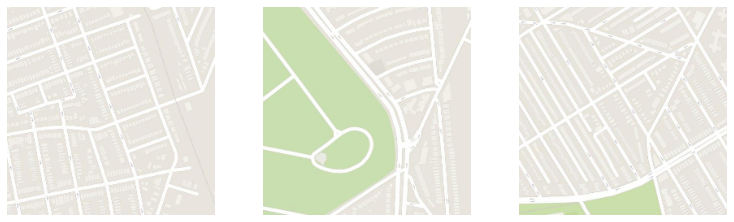

Epoch:0, Step:0, D-Loss:4.919, D-Acc:47.070, G-Loss:76.036
Epoch:0, Step:100, D-Loss:0.392, D-Acc:45.312, G-Loss:12.424
Epoch:0, Step:200, D-Loss:0.241, D-Acc:71.094, G-Loss:8.243
Epoch:0, Step:300, D-Loss:0.718, D-Acc:73.633, G-Loss:8.938
Epoch:0, Step:400, D-Loss:0.188, D-Acc:74.609, G-Loss:21.487
Epoch:0, Step:500, D-Loss:0.135, D-Acc:89.062, G-Loss:8.117
Epoch:0, Step:600, D-Loss:0.097, D-Acc:88.086, G-Loss:9.455
Epoch:0, Step:700, D-Loss:0.377, D-Acc:54.297, G-Loss:10.299
Epoch:0, Step:800, D-Loss:0.029, D-Acc:99.805, G-Loss:14.020
Epoch:0, Step:900, D-Loss:0.137, D-Acc:84.961, G-Loss:19.451
Epoch:0, Step:1000, D-Loss:0.131, D-Acc:83.789, G-Loss:8.633
Epoch:1, Step:0, D-Loss:0.510, D-Acc:52.734, G-Loss:13.977
Epoch:1, Step:100, D-Loss:0.020, D-Acc:100.000, G-Loss:11.472
Epoch:1, Step:200, D-Loss:0.155, D-Acc:68.945, G-Loss:10.354
Epoch:1, Step:300, D-Loss:0.176, D-Acc:71.484, G-Loss:6.621
Epoch:1, Step:400, D-Loss:0.237, D-Acc:55.469, G-Loss:8.334
Epoch:1, Step:500, D-Loss:0.035, 

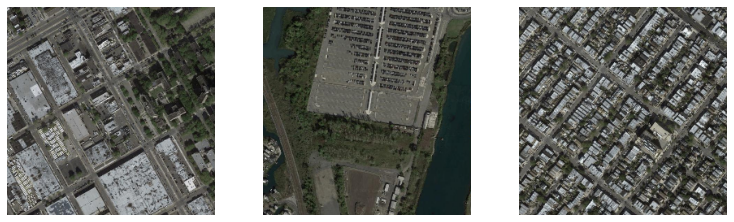

Predicted Output Images


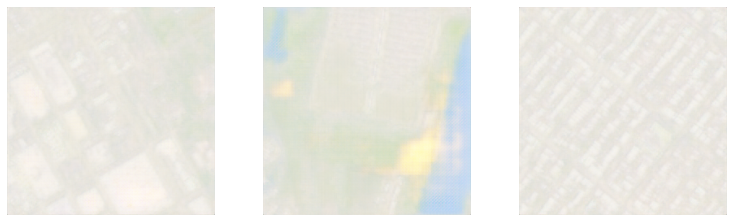

Real Output Images


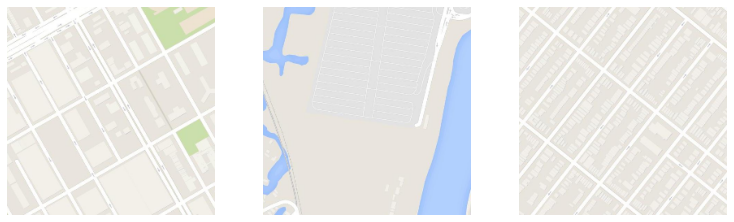

Epoch:5, Step:0, D-Loss:0.008, D-Acc:100.000, G-Loss:12.612
Epoch:5, Step:100, D-Loss:0.003, D-Acc:100.000, G-Loss:18.002
Epoch:5, Step:200, D-Loss:0.013, D-Acc:100.000, G-Loss:14.298
Epoch:5, Step:300, D-Loss:0.033, D-Acc:100.000, G-Loss:16.246
Epoch:5, Step:400, D-Loss:0.018, D-Acc:100.000, G-Loss:7.795
Epoch:5, Step:500, D-Loss:0.032, D-Acc:99.414, G-Loss:9.867
Epoch:5, Step:600, D-Loss:0.006, D-Acc:100.000, G-Loss:20.094
Epoch:5, Step:700, D-Loss:0.020, D-Acc:100.000, G-Loss:7.975
Epoch:5, Step:800, D-Loss:0.031, D-Acc:100.000, G-Loss:6.849
Epoch:5, Step:900, D-Loss:0.010, D-Acc:100.000, G-Loss:6.367
Epoch:5, Step:1000, D-Loss:0.003, D-Acc:100.000, G-Loss:5.760
Epoch:6, Step:0, D-Loss:0.166, D-Acc:71.875, G-Loss:11.278
Epoch:6, Step:100, D-Loss:0.012, D-Acc:100.000, G-Loss:11.712
Epoch:6, Step:200, D-Loss:0.013, D-Acc:100.000, G-Loss:6.622
Epoch:6, Step:300, D-Loss:0.009, D-Acc:100.000, G-Loss:9.777
Epoch:6, Step:400, D-Loss:0.004, D-Acc:100.000, G-Loss:14.475
Epoch:6, Step:500, D-

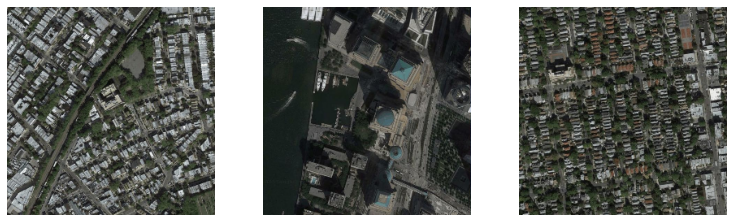

Predicted Output Images


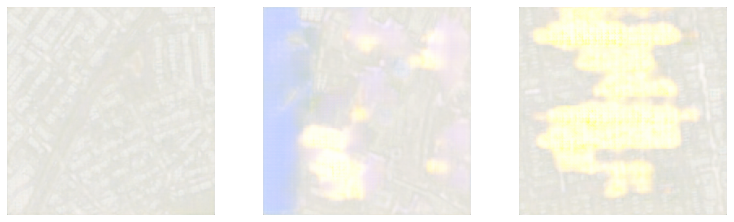

Real Output Images


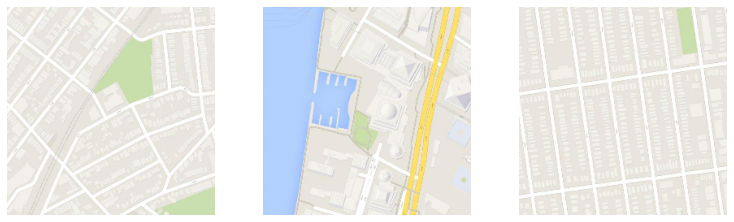

Epoch:10, Step:0, D-Loss:0.001, D-Acc:100.000, G-Loss:9.479
Epoch:10, Step:100, D-Loss:0.002, D-Acc:100.000, G-Loss:7.527
Epoch:10, Step:200, D-Loss:0.065, D-Acc:97.070, G-Loss:7.427
Epoch:10, Step:300, D-Loss:0.001, D-Acc:100.000, G-Loss:10.724
Epoch:10, Step:400, D-Loss:0.008, D-Acc:100.000, G-Loss:5.988
Epoch:10, Step:500, D-Loss:0.003, D-Acc:100.000, G-Loss:20.368
Epoch:10, Step:600, D-Loss:0.006, D-Acc:100.000, G-Loss:7.253
Epoch:10, Step:700, D-Loss:0.079, D-Acc:95.703, G-Loss:10.346
Epoch:10, Step:800, D-Loss:0.005, D-Acc:100.000, G-Loss:9.772
Epoch:10, Step:900, D-Loss:0.040, D-Acc:99.609, G-Loss:8.725
Epoch:10, Step:1000, D-Loss:0.003, D-Acc:100.000, G-Loss:11.216
Epoch:11, Step:0, D-Loss:0.007, D-Acc:100.000, G-Loss:5.344
Epoch:11, Step:100, D-Loss:0.003, D-Acc:100.000, G-Loss:8.484
Epoch:11, Step:200, D-Loss:0.007, D-Acc:100.000, G-Loss:11.823
Epoch:11, Step:300, D-Loss:0.125, D-Acc:81.250, G-Loss:19.586
Epoch:11, Step:400, D-Loss:0.006, D-Acc:100.000, G-Loss:5.342
Epoch:11,

In [ ]:
epochs = 500
batch_size = 1
steps = 1096

for i in range(0, epochs):
    if (i%5 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        maps_input, maps_output = get_map_samples(batch_size=batch_size)
        generated_maps_output = get_generated_samples(generator_network, maps_input)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d1 = discriminator_network.train_on_batch([maps_input, maps_output], real_patch)
        loss_d2 = discriminator_network.train_on_batch([maps_input, generated_maps_output], fake_patch)
        
        loss_d = (np.add(loss_d1, loss_d2))/2.0
        
        
        maps_input, maps_output = get_map_samples(batch_size=batch_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g, _, _ = pix2pix.train_on_batch(maps_input, [real_patch, maps_output])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))   